# PANAS

Comparing subjective negative affect, assessed via positive and negative affect schedule (PANAS) immediately before and after SECPT. 

In [47]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from scipy import stats
import seaborn as sns
import warnings
from utils import *

warnings.filterwarnings('ignore', category=FutureWarning)

%run behav_starter.py

subid2group = usable_subinfo[["subid", "group"]].rename(columns={'subid': 'subID'})
def convertgrp(grp):
    if grp == 0:
        return "Control"
    elif grp == 1:
        return "Stress"
    else:
        return None
        
subid2group["group"] = subid2group["group"].apply(convertgrp)
subid2group_str = subid2group.copy()
subid2group_str["subID"] = subid2group_str["subID"].apply(lambda x: str(x))


Controls:  47
Stress:  49


In [48]:
panas_pre_file = "./data/questionnaires/StressLearn_PANAS_preSECPT.csv"
panas_post_file = "./data/questionnaires/StressLearn_PANAS_postSECPT.csv"

panas_pos_cols = ["panas_ex_1","panas_ex_3","panas_ex_5","panas_ex_9","panas_ex_10","panas_ex_12","panas_ex_14","panas_ex_16","panas_ex_17","panas_ex_19"]
panas_neg_cols = ["panas_ex_2","panas_ex_4","panas_ex_6","panas_ex_7","panas_ex_8","panas_ex_11","panas_ex_13","panas_ex_15","panas_ex_18","panas_ex_20"]
panas_cols = panas_pos_cols + panas_neg_cols
all_cols = ["src_subject_id"] + panas_cols

panas_pre_df = pd.read_csv(panas_pre_file)[all_cols].iloc[2:].reset_index(drop=True)
panas_post_df = pd.read_csv(panas_post_file)[all_cols].iloc[2:].reset_index(drop=True)

# treating NaN (no response) as 0
for col in panas_pos_cols + panas_neg_cols:
    panas_pre_df[col] = pd.to_numeric(panas_pre_df[col], errors='coerce').fillna(0)
    panas_post_df[col] = pd.to_numeric(panas_post_df[col], errors='coerce').fillna(0)


prepost_df = subid2group_str
for survey, file in zip(["pre", "post"], [panas_pre_file, panas_post_file]):
    df = pd.read_csv(file)[all_cols].iloc[2:].reset_index(drop=True)
    df["subID"] = df["src_subject_id"].apply(lambda x: x[1:])
    
    for col in panas_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

    for name, cols in zip(["pos_avg", "neg_avg"], [panas_pos_cols, panas_neg_cols]):
        df[name] = np.mean(df[cols], axis=1)

    newdf = df[['subID', 'pos_avg', 'neg_avg']].rename(columns={"pos_avg": f"{survey}_pos_avg", "neg_avg": f"{survey}_neg_avg"})
    prepost_df = pd.merge(prepost_df, newdf, on="subID", how="left")
        
prepost_df["subID"] = prepost_df["subID"].apply(lambda x: int(x))

viz_df = prepost_df.melt(id_vars=["subID", "group"], value_vars=np.array(prepost_df.columns)[["avg" in c for c in prepost_df.columns]], value_name="score")
viz_df["time"] = viz_df["variable"].apply(lambda x: {"pre": "pre-SECPT", "post": "post-SECPT"}[x.split('_')[0]])
viz_df["valence"] = viz_df["variable"].apply(lambda x: {"pos": "Positive", "neg": "Negative"}[x.split('_')[1]])
viz_df = viz_df.drop(columns="variable")
viz_df = viz_df.pivot(index=["subID", "group", "valence"], columns="time", values="score").reset_index().dropna().melt(id_vars=["subID", "group", "valence"], value_vars=["pre-SECPT", "post-SECPT"], value_name="score")


In [49]:
def get_star_x_y(ax, df, xcol, huecol, valcol, xorder, hueorder, points=True):
    barxs = np.reshape([line.get_data()[0][0] for line in ax.get_lines()[:len(hueorder)*len(xorder)]], (len(hueorder), len(xorder))).T
    if points:
        barys = []
        for hue in hueorder:
            for x in xorder:
                barys.append(np.max(df.loc[(df[xcol] == x) & (df[huecol] == hue)][valcol]))
        barys = np.reshape(barys, (len(hueorder), len(xorder))).T
        
    else:
        barys = np.reshape([line.get_data()[1][1] for line in ax.get_lines()[:len(hueorder)*len(xorder)]], (len(hueorder), len(xorder))).T

    return barxs, barys


def add_sig_compare_line(ax, linex, stary, yshift=None):
    if yshift is None:
        yshift = np.diff(ax.get_ylim())[0]*0.05
    
    ax.hlines(y=stary, xmin=linex[0], xmax=linex[1], color='k', linewidth=1)
    ax.vlines(x=linex[0], ymin=stary-yshift*0.2, ymax=stary, color='k', capstyle='projecting', linewidth=1)
    ax.vlines(x=linex[1], ymin=stary-yshift*0.2, ymax=stary, color='k', capstyle='projecting', linewidth=1)
    

Control [-4.055319148936171, -0.8021276595744682] 0.0011800118001180013
Stress [0.881145833333334, 5.625] 0.009060090600906009
Stress v Control [2.743834219858156, 8.506784131205674] 0.00024000240002400024


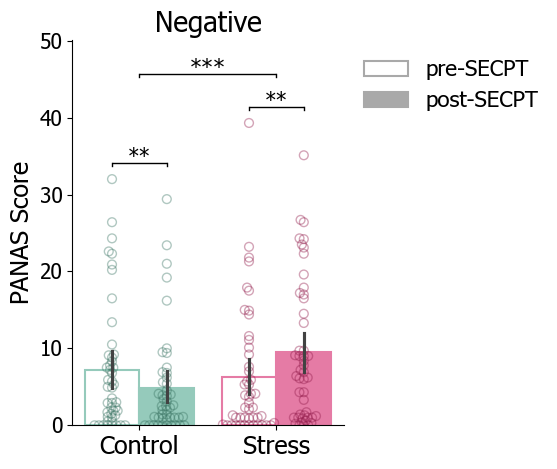

In [58]:
np.random.seed(0)
groups = ["Control", "Stress"]
times = ["pre-SECPT", "post-SECPT"]
valence = "Negative"
color='darkgray'

val_viz_df = viz_df[viz_df["valence"] == valence].drop(columns="valence")

fig, ax = plt.subplots(1, 1, figsize=(3.5, 5))
sns.barplot(data=val_viz_df, x="group", y="score", hue="time", order=groups, hue_order=times, palette=[color]*len(times))
sns.swarmplot(data=val_viz_df, x="group", y="score", hue="time", order=groups, hue_order=times, dodge=True, s=3, alpha=0)

x_scatters = []
y_scatters = []


# add dots
for i in np.arange(len(groups)):
    for j in np.arange(len(times)):
        k = i*len(times) + j
        x_data, y_data = ax.collections[k].get_offsets().T
    
        ax.scatter(x_data, y_data, color="None", s=40, alpha=0.4, edgecolor=dark_group_colors[i], linewidth=1)
        
        x_scatters.append(x_data)
        y_scatters.append(y_data)

# add barstyle
for i, bar in enumerate(ax.patches):
    if i < len(groups)*len(times):
        if i//len(groups) == 0:
            bar.set_color('white')
        else:
            bar.set_color(group_colors[i%len(groups)])
        bar.set_edgecolor(group_colors[i%len(groups)])
        bar.set_linewidth(1.5)

# add significance stars
barxs, barys = get_star_x_y(ax, val_viz_df, xcol="group", huecol="time", valcol="score", xorder=groups, hueorder=times)
yshift = np.diff(ax.get_ylim())[0]*0.05
max_stary = 0

# within-group comparisons
compare_df = val_viz_df.pivot(index=["subID", "group"], columns="time", values="score").reset_index().dropna()
compare_df["change"] = compare_df["post-SECPT"] - compare_df["pre-SECPT"]

for groupi, group in zip(np.arange(len(groups)), groups):
    grp_df = compare_df[compare_df["group"] == group]
    grp_secpt_diff = np.array(grp_df["change"])
    CI, pval = simple_bootstrap(grp_secpt_diff, iterations=99999, null=0)
    pval = pval*2
    star = pval2star(pval)

    print(group, CI, pval)

    linex = barxs[groupi]
    stary = np.max(barys[groupi]) + yshift
    if stary > max_stary:
        max_stary = stary
    add_sig_compare_line(ax, linex, stary, yshift=yshift)
    ax.text(x=np.mean(linex), y=stary, s=star, ha="center")

# compare difference between pre-SECPT and post-SECPT across groups
CI, pval = simple_bootstrap_2group(np.array(compare_df[compare_df["group"] == "Stress"]["change"]), np.array(compare_df[compare_df["group"] == "Control"]["change"]), iterations=99999, null=0, onetail_hyp="above")
pval = 2*pval
print("Stress v Control", CI, pval)
star = pval2star(pval)
if star != '':
    yshift = np.diff(ax.get_ylim())[0]*0.05
    linex = np.mean(barxs, axis=1)
    starx = np.mean(linex)
    stary = np.max([np.max(val_viz_df["score"])+yshift, max_stary + yshift*2])

    add_sig_compare_line(ax, linex, stary, yshift=yshift)
    ax.text(x=starx, y=stary, s=star, horizontalalignment="center", fontsize=16)

    ax.set_ylim(ax.get_ylim()[0], np.max([ax.get_ylim()[1], stary+yshift*2]))


legend_elements = [Patch(facecolor="white", edgecolor=color, linewidth=1.5, label=times[0]), 
                   Patch(facecolor=color, edgecolor=color, linewidth=1.5, label=times[1])]

plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1), fontsize=16, frameon=False)
ax.set_title(valence, fontsize=20)
ax.set_xlabel("")
ax.set_ylabel("PANAS Score", fontsize=18)
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(groups, fontsize=18)

sns.despine()

